# Notebook 4b: Feature Importance

This notebook will show how to use Permutation Importance in fastai tabular. In order to do permutation importance, we need 3 (4 if you have your own test set) sets of data:

1. Training set
2. Validation set
3. Test set (optional)
4. Feature Importance test set

We want a seperate set than that of what we are training with so there is no inherit biases to our data. The code we will use today is based off of Pak's (on the forums) 1.0 implementation. The original post is [here](https://forums.fast.ai/t/football-transfer-case-as-an-example-of-feature-importance-and-partial-dependence-in-tabular-models/56949)

First let's get our libraries

In [0]:
!pip3 install torch===1.3.0 torchvision===0.4.1 -f https://download.pytorch.org/whl/torch_stable.html
!pip install git+https://github.com/fastai/fastai_dev > /dev/null

In [0]:
from fastai2.torch_basics import *
from fastai2.basics import *
from fastai2.tabular.core import *

In [0]:
path = untar_data(URLs.ADULT_SAMPLE)
df = pd.read_csv(path/'adult.csv')

From here we'll split into our three datasets (training and validation will be done in one and use RandomSplitting). In terms of pecentage, we want the test and feature importance sets to be 10% of our data, and the other 80% our training data

In [5]:
len(df) * .8

26048.800000000003

In [7]:
(len(df) * .1) + 26048

29304.1

In [0]:
train_df = df.iloc[:26048]
test_df = df.iloc[26048:29304]
fi = df.iloc[29304:]

Now that we have this, let's train a **full** model

In [0]:
cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race']
cont_names = ['age', 'fnlwgt', 'education-num']
procs = [Categorify, FillMissing, Normalize]

The following code is just to get our `TabularLearner` up and running

In [0]:
def emb_sz_rule(n_cat): 
    "Rule of thumb to pick embedding size corresponding to `n_cat`"
    return min(600, round(1.6 * n_cat**0.56))

def _one_emb_sz(classes, n, sz_dict=None):
    "Pick an embedding size for `n` depending on `classes` if not given in `sz_dict`."
    sz_dict = ifnone(sz_dict, {})
    n_cat = len(classes[n])
    sz = sz_dict.get(n, int(emb_sz_rule(n_cat)))  # rule of thumb
    return n_cat,sz

def get_emb_sz(to, sz_dict=None):
    "Get default embedding size from `TabularPreprocessor` `proc` or the ones in `sz_dict`"
    return [_one_emb_sz(to.procs.classes, n, sz_dict) for n in to.cat_names]

class TabularModel(Module):
    "Basic model for tabular data."
    def __init__(self, emb_szs, n_cont, out_sz, layers, ps=None, embed_p=0., y_range=None, use_bn=True, bn_final=False):
        ps = ifnone(ps, [0]*len(layers))
        if not is_listy(ps): ps = [ps]*len(layers)
        self.embeds = nn.ModuleList([Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(embed_p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        n_emb = sum(e.embedding_dim for e in self.embeds)
        self.n_emb,self.n_cont,self.y_range = n_emb,n_cont,y_range
        sizes = [n_emb + n_cont] + layers + [out_sz]
        actns = [nn.ReLU(inplace=True) for _ in range(len(sizes)-2)] + [None]
        _layers = [BnDropLin(sizes[i], sizes[i+1], bn=use_bn and i!=0, p=p, act=a)
                       for i,(p,a) in enumerate(zip([0.]+ps,actns))]
        if bn_final: _layers.append(nn.BatchNorm1d(sizes[-1]))
        self.layers = nn.Sequential(*_layers)
    
    def forward(self, x_cat, x_cont):
        if self.n_emb != 0:
            x = [e(x_cat[:,i]) for i,e in enumerate(self.embeds)]
            x = torch.cat(x, 1)
            x = self.emb_drop(x)
        if self.n_cont != 0:
            x_cont = self.bn_cont(x_cont)
            x = torch.cat([x, x_cont], 1) if self.n_emb != 0 else x_cont
        x = self.layers(x)
        if self.y_range is not None:
            x = (self.y_range[1]-self.y_range[0]) * torch.sigmoid(x) + self.y_range[0]
        return x

In [0]:
# My own mock version of a `tabular_learner`
def tabular_learner(data:DataBunch, layers, emb_szs=None, metrics=None,
        ps=None, emb_drop:float=0., y_range=None, use_bn:bool=True, **learn_kwargs):
    "Get a `Learner` using `data`, with `metrics`, including a `TabularModel` created using the remaining params."
    emb_szs = get_emb_sz(data.train)
    model = TabularModel(emb_szs, len(data.cont_names), data.train[data.train.y_names].nunique(), layers=layers)
    return Learner(data, model, metrics=metrics, **learn_kwargs)

In [0]:
splits = RandomSplitter()(range_of(train_df))

In [0]:
to = TabularPandas(train_df, procs, cat_names, cont_names, y_names="salary", splits=splits)
data = to.databunch()

In [17]:
learn = tabular_learner(data, layers=[200,100], loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn.fit(5)

(#5) [0,0.40297701954841614,0.3691259026527405,0.8287579417228699,00:32]
(#5) [1,0.3910473585128784,0.3549399971961975,0.8358610272407532,00:32]
(#5) [2,0.3940655291080475,0.3611099123954773,0.8398925065994263,00:32]
(#5) [3,0.3856392800807953,0.35575807094573975,0.8435400128364563,00:32]
(#5) [4,0.3582382798194885,0.3530307114124298,0.8395085334777832,00:32]


Now that the model is trained, let's do permutation importance. But what is it? And how will it work? 

We train a full model and then shuffle the input columns and measure the change in accuracy afterwards. This will give us a tangeable viewing of how each variable in our tabular model affects the output (and how much it was needed)

Here is the code:

In [0]:
class CalcPermutationImportance():
  def __init__(self, df:pd.DataFrame, learn:Learner, rounds:int):
    self.df, self.learn, self.rounds = df, learn, rounds
    dbunch = learn.dbunch
    self.procs = dbunch.procs
    self.cats, self.conts = dbunch.cat_names, dbunch.cont_names
    self.cats = self.cats.filter(lambda x: '_na' not in x)
    self.y = dbunch.y_names
    self.results = self.calc_feat_importance()
    self.plot_importance(self.ord_dic_to_df(self.results))
    
  def calc_feat_importance(self):
    to_test = TabDataLoader(TabularPandas(self.df, self.procs, self.cats.copy(), self.conts, self.y))
    base_error = self.learn.validate(dl=to_test)[1]
    self.importance = {}
    pbar = master_bar(self.cats + self.conts, total=len(self.cats + self.conts))
    for col in pbar:
      self.importance[col] = self.calc_error(col)
      _ = progress_bar(range(1), display=False, parent=pbar)
      
    for key, value in self.importance.items():
        self.importance[key] = (value - base_error)/base_error
    return collections.OrderedDict(sorted(self.importance.items(), key=lambda kv: kv[1], reverse=True))
  
  def calc_error(self, sample_col:Str):
    df_temp = pd.concat([self.df]*self.rounds, ignore_index=True).copy()
    
    df_temp[sample_col] = np.random.permutation(df_temp[sample_col].values)
    to_test = TabDataLoader(TabularPandas(df_temp, self.procs, self.cats.copy(), self.conts, self.y))
    return self.learn.validate(dl=to_test)[1]
  
  def ord_dic_to_df(self, ord_dict:OrderedDict)->pd.DataFrame:
      return pd.DataFrame([[k, v] for k, v in ord_dict.items()], columns=['feature', 'importance'])
    
  def plot_importance(self, df:pd.DataFrame, limit=20, asc=False):
    df_copy = df.copy()
    df_copy['feature'] = df_copy['feature'].str.slice(0,25)
    ax = df_copy.sort_values(by='importance', ascending=asc)[:limit].sort_values(by='importance', ascending=not(asc)).plot.barh(x="feature", y="importance", sort_columns=True, figsize=(10, 10))
    for p in ax.patches:
        ax.annotate(f'{p.get_width():.4f}', ((p.get_width() * 1.005), p.get_y()  * 1.005))

In order to use this, we simply call`CalcPermutationImportance` and pass in our `fi` dataframe, our Learner, and how many rounds each variable will go through. For this example we will do five rounds. At the end a graph will be plotted showing the relative change for each variable

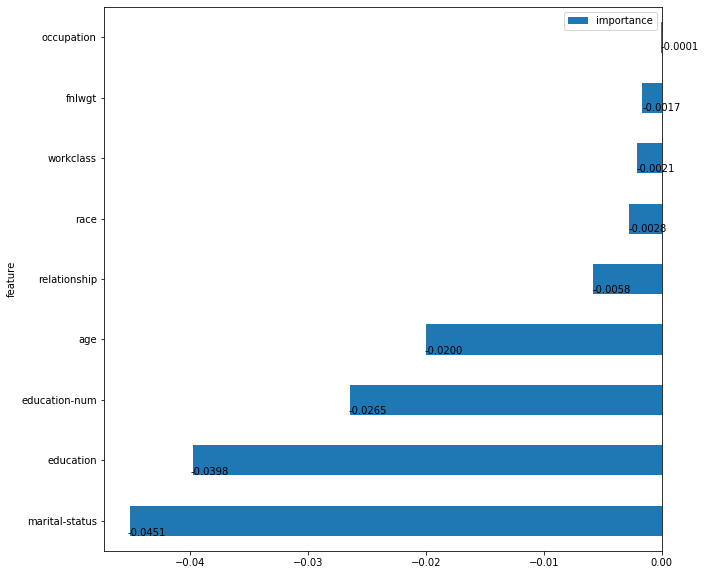

In [21]:
res = CalcPermutationImportance(fi, learn, 5)

To see the raw results, call `res.results`

In [22]:
res.results

OrderedDict([('occupation', -7.58559552853447e-05),
             ('fnlwgt', -0.0016691992490702307),
             ('workclass', -0.002124408627340828),
             ('race', -0.0028072595180259896),
             ('relationship', -0.005842160548466542),
             ('age', -0.020030317342284238),
             ('education-num', -0.026479546472709125),
             ('education', -0.039757210863427095),
             ('marital-status', -0.0450683060783377)])

To read this, the first (highest) value in the list is the most influential feature in the dataset, and the last (lowest) being the least.

Here, 'occupation' was the most influential and 'marital-status' was the least.

Thanks for reading!